### Notebook for the label transfer of WT mice CMC to rest of CMC genotypes with `scANVI`

- **Developed by:** Carlos Talavera-López Ph.D
- **Würzburg Institute for Systems Immunology - Faculty of Medicine - Julius-Maximilian-Universität Würzburg**
- v240205

### Import required modules

In [1]:
import scvi
import torch
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as p
from pywaffle import Waffle
import matplotlib.pyplot as plt
from scib_metrics.benchmark import Benchmarker

/home/ruth/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/ruth/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/ruth/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/hom

### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.5.post1
scanpy      1.9.8
-----
PIL                 10.0.0
absl                NA
aiohttp             3.8.5
aiosignal           1.3.1
annotated_types     0.5.0
anyio               NA
asttokens           NA
async_timeout       4.0.3
attr                23.1.0
backcall            0.2.0
backoff             2.2.1
bs4                 4.12.2
certifi             2023.07.22
charset_normalizer  3.2.0
chex                0.1.7
click               8.1.7
comm                0.1.4
contextlib2         NA
croniter            NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7.post1
decorator           5.1.1
deepdiff            6.3.1
docrep              0.3.2
etils               1.4.1
exceptiongroup      1.1.3
executing           1.2.0
fastapi             0.103.0
flax                0.7.2
frozenlist          1.4.0
fsspec              2023.6.0
h5py                3.9.0
idna                3.4
igraph              0.10.8
importli

In [3]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'
torch.set_float32_matmul_precision('medium')

Global seed set to 1712


In [4]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 3,
)

### Read in data

In [5]:
heart_scANVI = sc.read_h5ad('../../../data/Kdm6aKO_ALL_GEX-CB_scANVI-CMC_ctl240205.raw.h5ad')
heart_scANVI

AnnData object with n_obs × n_vars = 10793 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'group', 'file', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'genome', 'modality', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [6]:
heart_scANVI.obs_names = [name.rsplit('-', 1)[0] for name in heart_scANVI.obs_names]
heart_scANVI.obs_names

Index(['AAACAGCCAGGCCATT-1-KDM6A_wt_11-query',
       'AAACATGCAAACCTAT-1-KDM6A_wt_11-query',
       'AAACATGCACACCAAC-1-KDM6A_wt_11-query',
       'AAACCAACAAACAACA-1-KDM6A_wt_11-query',
       'AAACCAACAGTTTCTC-1-KDM6A_wt_11-query',
       'AAACCGAAGGTGAGAC-1-KDM6A_wt_11-query',
       'AAACCGAAGTCATTAG-1-KDM6A_wt_11-query',
       'AAACCGCGTTAAGTGT-1-KDM6A_wt_11-query',
       'AAACCGCGTTACCGGG-1-KDM6A_wt_11-query',
       'AAACGCGCAGTATGTT-1-KDM6A_wt_11-query',
       ...
       'TTTGAGTCATAAGCAA-1-GSKJ4_treat_52-query',
       'TTTGAGTCATGCAACC-1-GSKJ4_treat_52-query',
       'TTTGAGTCATGCTCCC-1-GSKJ4_treat_52-query',
       'TTTGCATTCGGTTTCC-1-GSKJ4_treat_52-query',
       'TTTGGCTGTAAGCACC-1-GSKJ4_treat_52-query',
       'TTTGGCTGTTCACCAT-1-GSKJ4_treat_52-query',
       'TTTGGTAAGGGATTAG-1-GSKJ4_treat_52-query',
       'TTTGTCTAGTACTGGT-1-GSKJ4_treat_52-query',
       'TTTGTCTAGTCATGCG-1-GSKJ4_treat_52-query',
       'TTTGTTGGTCCTAACT-1-GSKJ4_treat_52-query'],
      dtype='objec

In [7]:
heart_scANVI.obs['seed_labels'] = heart_scANVI.obs['C_scANVI'].copy()
del(heart_scANVI.obs['C_scANVI'])
heart_scANVI

AnnData object with n_obs × n_vars = 10793 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'group', 'file', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'modality', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Visualise cell type distribution per condition

In [8]:
heart_scANVI.obs['seed_labels'].value_counts()

seed_labels
vCM1    5804
vCM4    1857
vCM2    1725
vCM3    1407
Name: count, dtype: int64

In [9]:
pd.crosstab(heart_scANVI.obs['seed_labels'], heart_scANVI.obs['genotype'])

genotype       KO  Sham    Tx    WT
seed_labels                        
vCM1         1182  1320  1464  1838
vCM2          704   357   278   386
vCM3          179   501   439   288
vCM4          222   761   167   707

### Read in other unannotated dataset and split into groups

In [10]:
heart_scANVI.obs['genotype'].value_counts()

genotype
WT      3219
Sham    2939
Tx      2348
KO      2287
Name: count, dtype: int64

In [11]:
reference = heart_scANVI[heart_scANVI.obs['genotype'].isin(['WT', 'Sham'])]
reference

View of AnnData object with n_obs × n_vars = 6158 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'group', 'file', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'modality', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [12]:
query = heart_scANVI[~heart_scANVI.obs['genotype'].isin(['WT', 'Sham'])]
query.obs['seed_labels'] = 'Unknown'
query

AnnData object with n_obs × n_vars = 4635 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'group', 'file', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'modality', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [13]:
adata = reference.concatenate(query, batch_key = 'batch', batch_categories = ['reference', 'query'], join = 'inner')
adata

AnnData object with n_obs × n_vars = 10793 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'group', 'file', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'modality', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

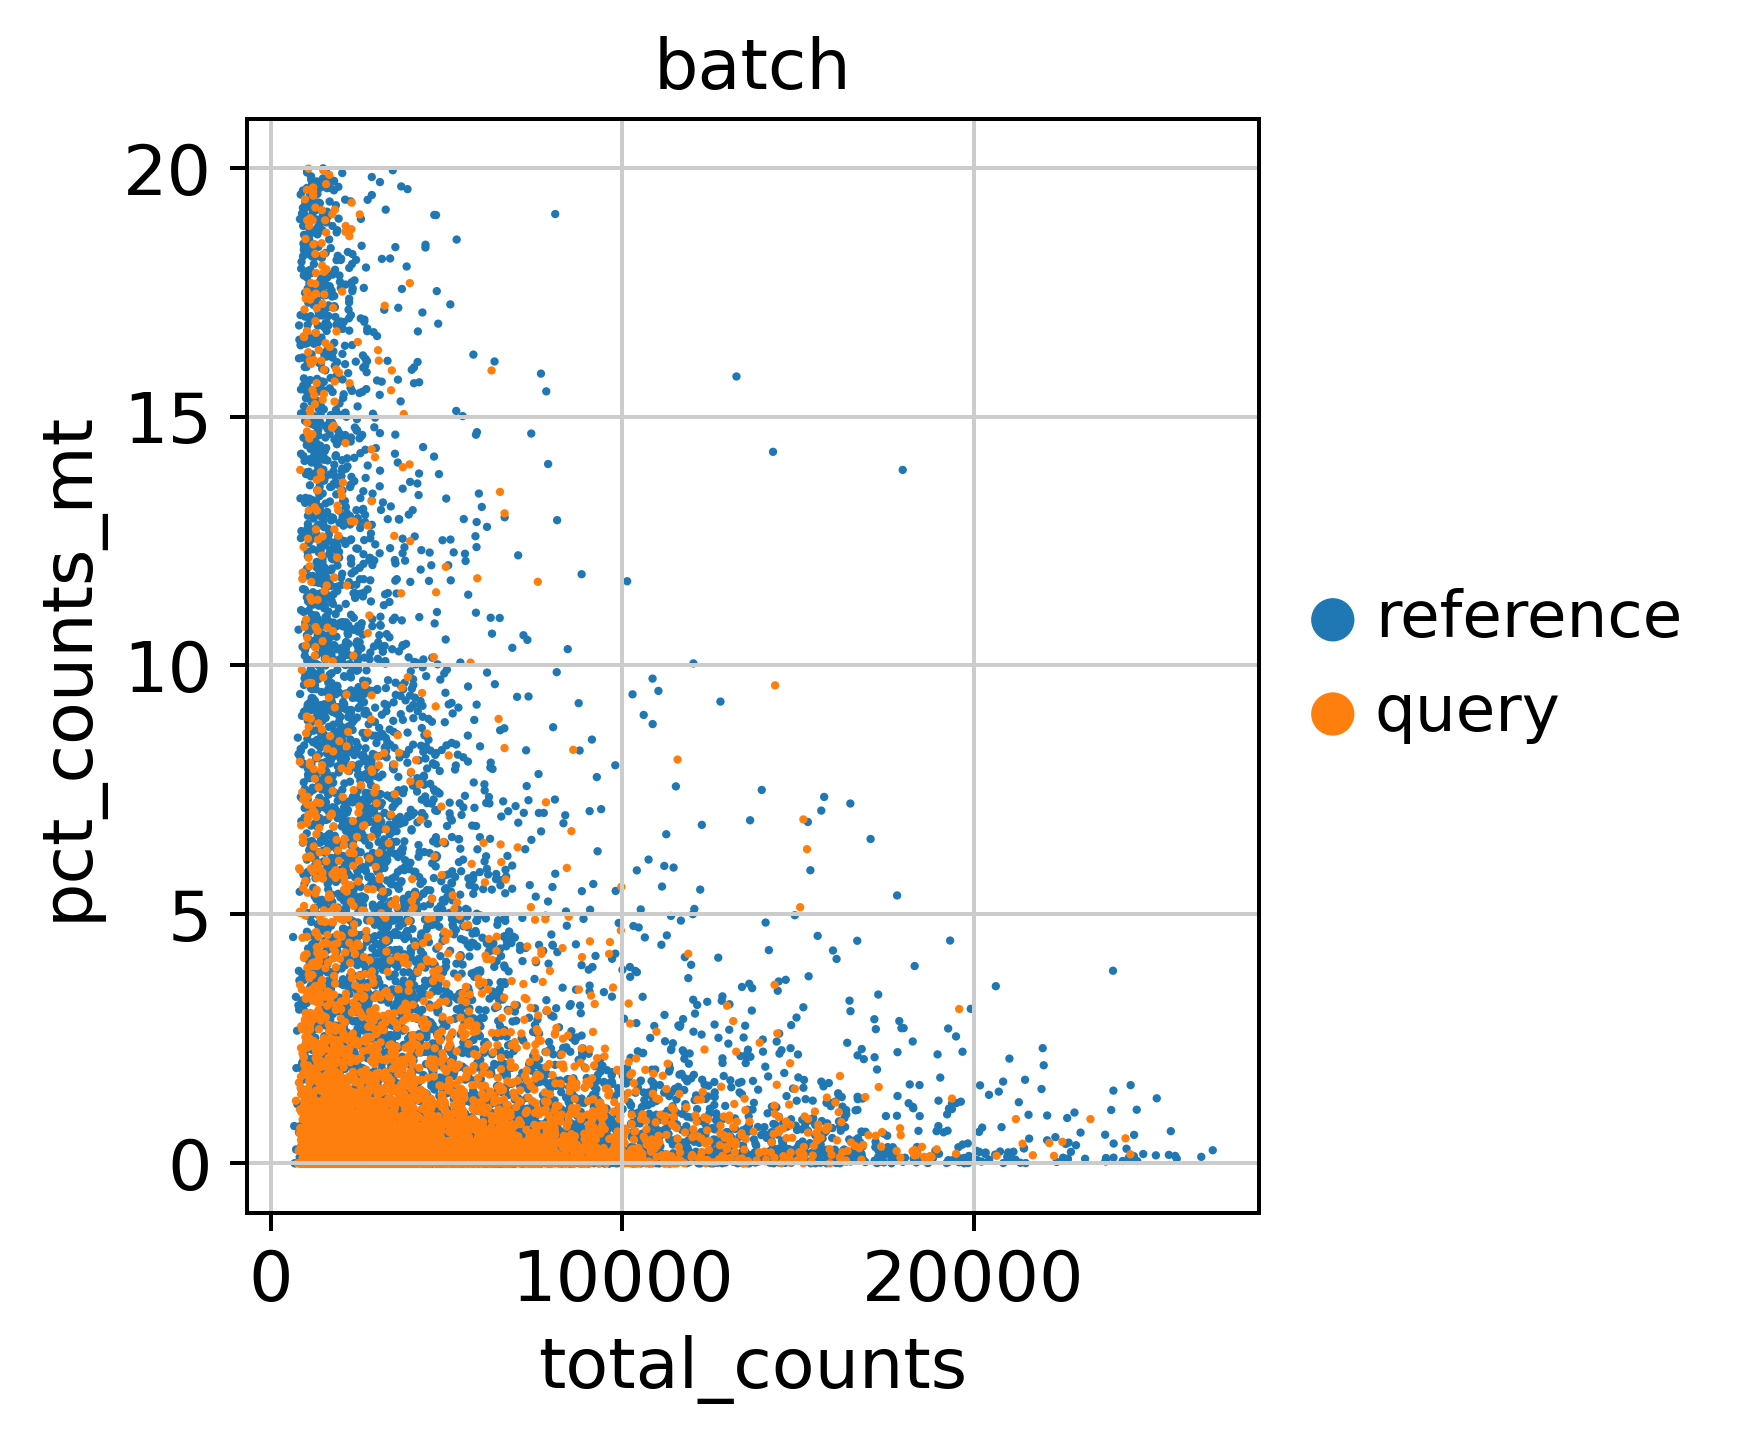

In [14]:
sc.pl.scatter(adata, x = 'total_counts', y = 'pct_counts_mt', color = "batch", frameon = False)

In [15]:
adata.obs['genotype'].value_counts()

genotype
WT      3219
Sham    2939
Tx      2348
KO      2287
Name: count, dtype: int64

In [16]:
adata.obs['sample'].value_counts()

sample
KDM6A_wt_11       2390
GSKJ4_sham_51     1551
GSKJ4_sham_57     1388
KDM6A_KO_34       1221
GSKJ4_treat_47    1220
GSKJ4_treat_52    1128
KDM6A_KO_31       1066
KDM6A_wt_40        829
Name: count, dtype: int64

### Select HVGs

In [17]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "sample",
    subset = True,
    span = 1
)
adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 10793 × 7000
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'group', 'file', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'modality', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'batch_colors', 'hvg'
    layers: 'counts'

### Transfer of annotation with scANVI

In [18]:
scvi.model.SCVI.setup_anndata(adata,
                              batch_key = "sample", 
                            categorical_covariate_keys = ["sample"], 
                            labels_key = "seed_labels", 
                            layer = 'counts')

In [19]:
scvi_model = scvi.model.SCVI(adata, 
                             n_latent = 50, 
                             n_layers = 3, 
                             dispersion = 'gene-batch', 
                             gene_likelihood = 'nb')

In [20]:
scvi_model.train(75, 
                 check_val_every_n_epoch = 1, 
                 enable_progress_bar = True, 
                 use_gpu = 1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 75/75: 100%|██████████| 75/75 [00:39<00:00,  1.90it/s, v_num=1, train_loss_step=1.9e+3, train_loss_epoch=1.85e+3] 

`Trainer.fit` stopped: `max_epochs=75` reached.


Epoch 75/75: 100%|██████████| 75/75 [00:39<00:00,  1.88it/s, v_num=1, train_loss_step=1.9e+3, train_loss_epoch=1.85e+3]


In [21]:
adata.obsm["X_scVI"] = scvi_model.get_latent_representation(adata)

### Evaluate model performance using the [_Svensson_](https://www.nxn.se/valent/2023/8/10/training-scvi-posterior-predictive-distributions-over-epochs) method

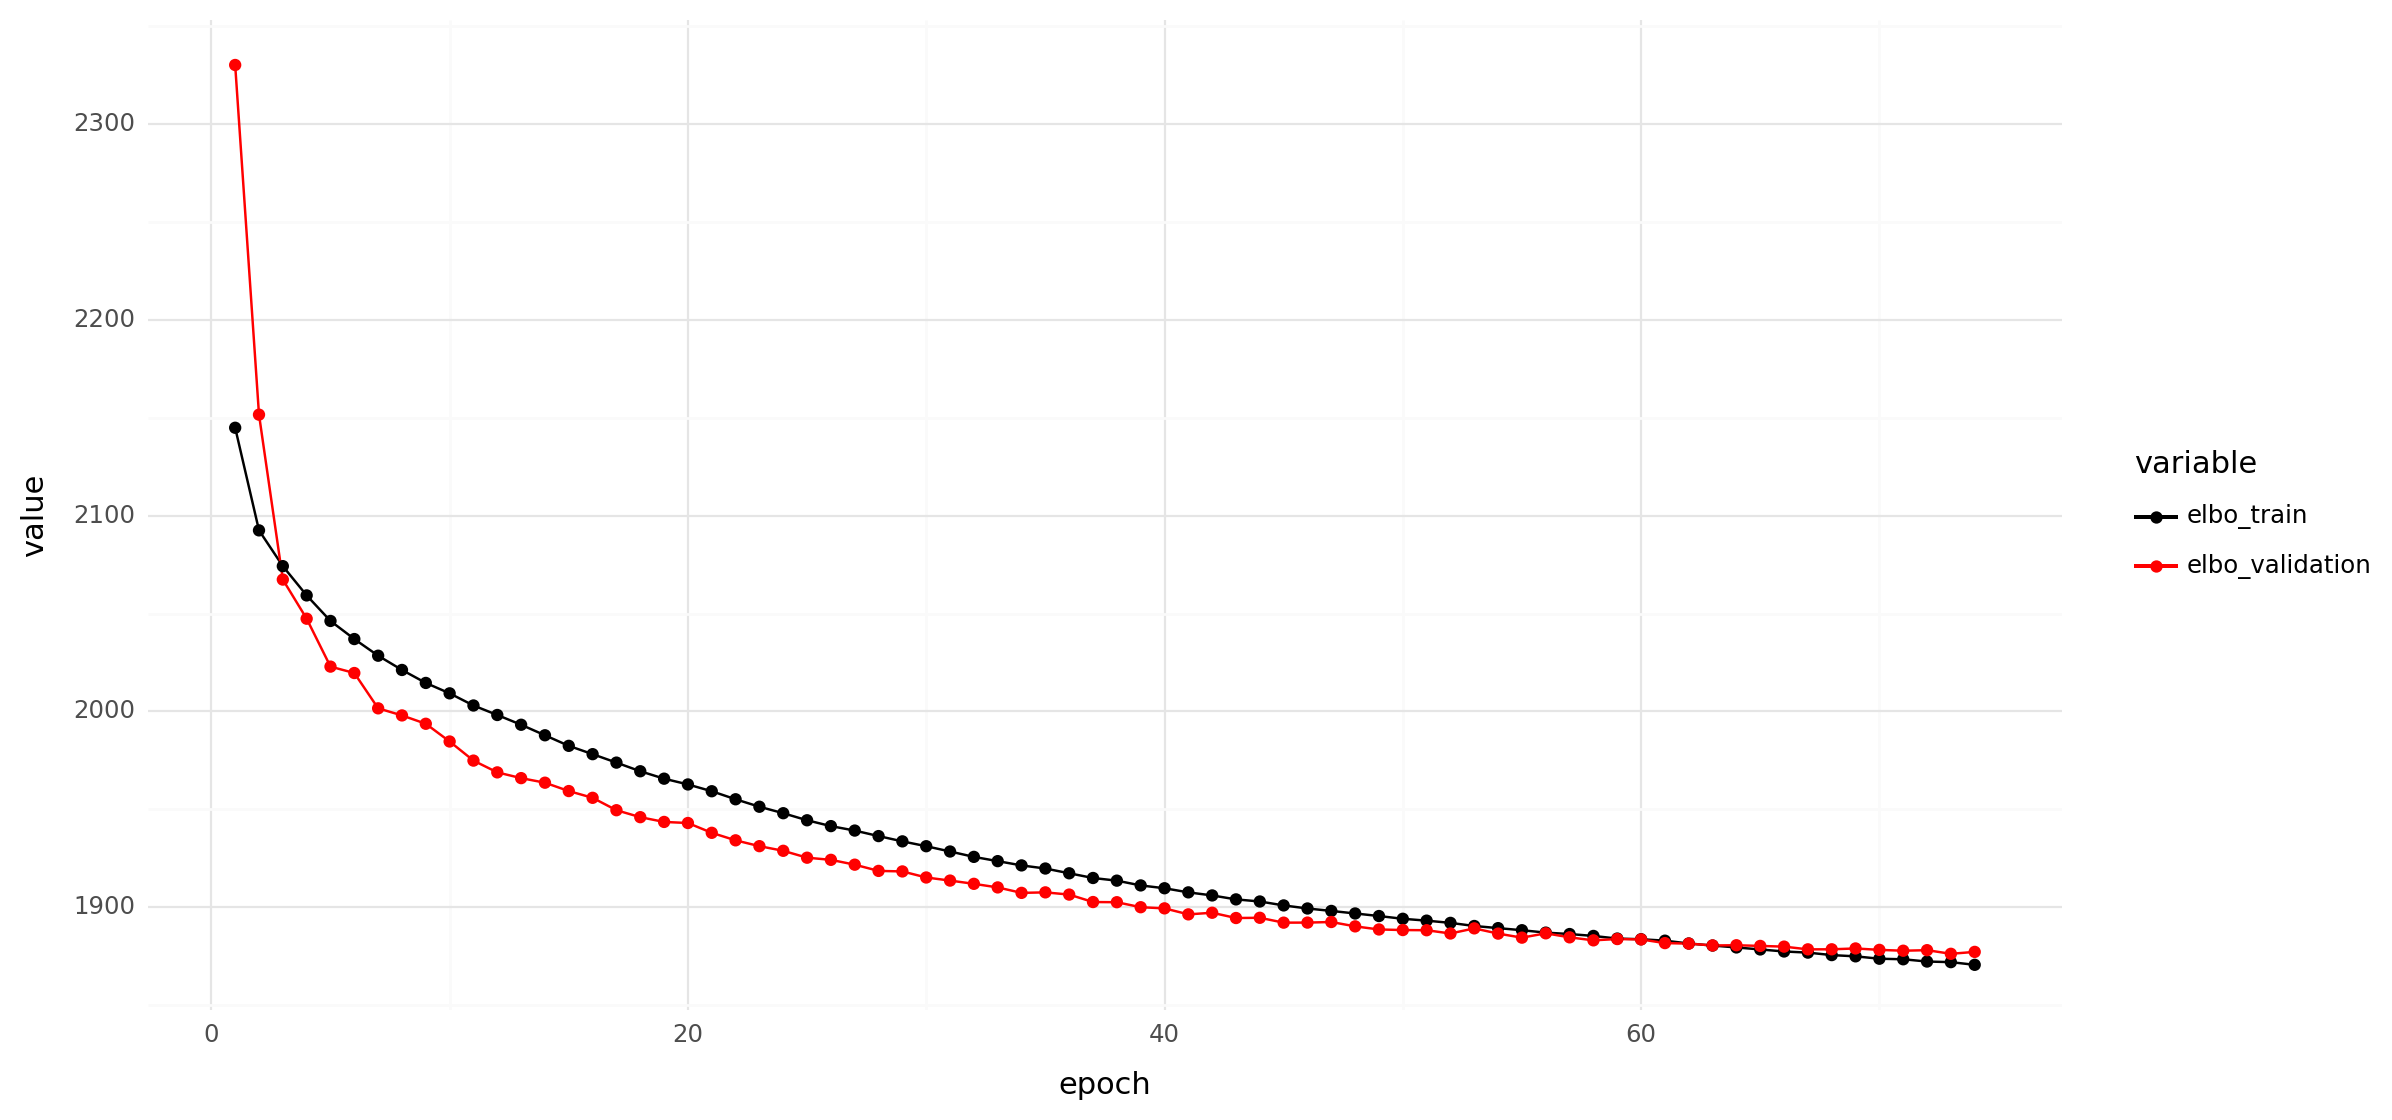

In [22]:
history_df = (
    scvi_model.history['elbo_train'].astype(float)
    .join(scvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

### Label transfer with `scANVI` 

In [23]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [24]:
scanvi_model.train(75, 
                   check_val_every_n_epoch = 1, 
                   enable_progress_bar = True, 
                   use_gpu = 1)

INFO     Training for 75 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 75/75: 100%|██████████| 75/75 [01:37<00:00,  1.04it/s, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.86e+3]

`Trainer.fit` stopped: `max_epochs=75` reached.


Epoch 75/75: 100%|██████████| 75/75 [01:37<00:00,  1.30s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.86e+3]


In [25]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

- Extract latent representation

In [26]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

### Explore model performance using the [_Svensson_](https://www.nxn.se/valent/2023/8/10/training-scvi-posterior-predictive-distributions-over-epochs) method

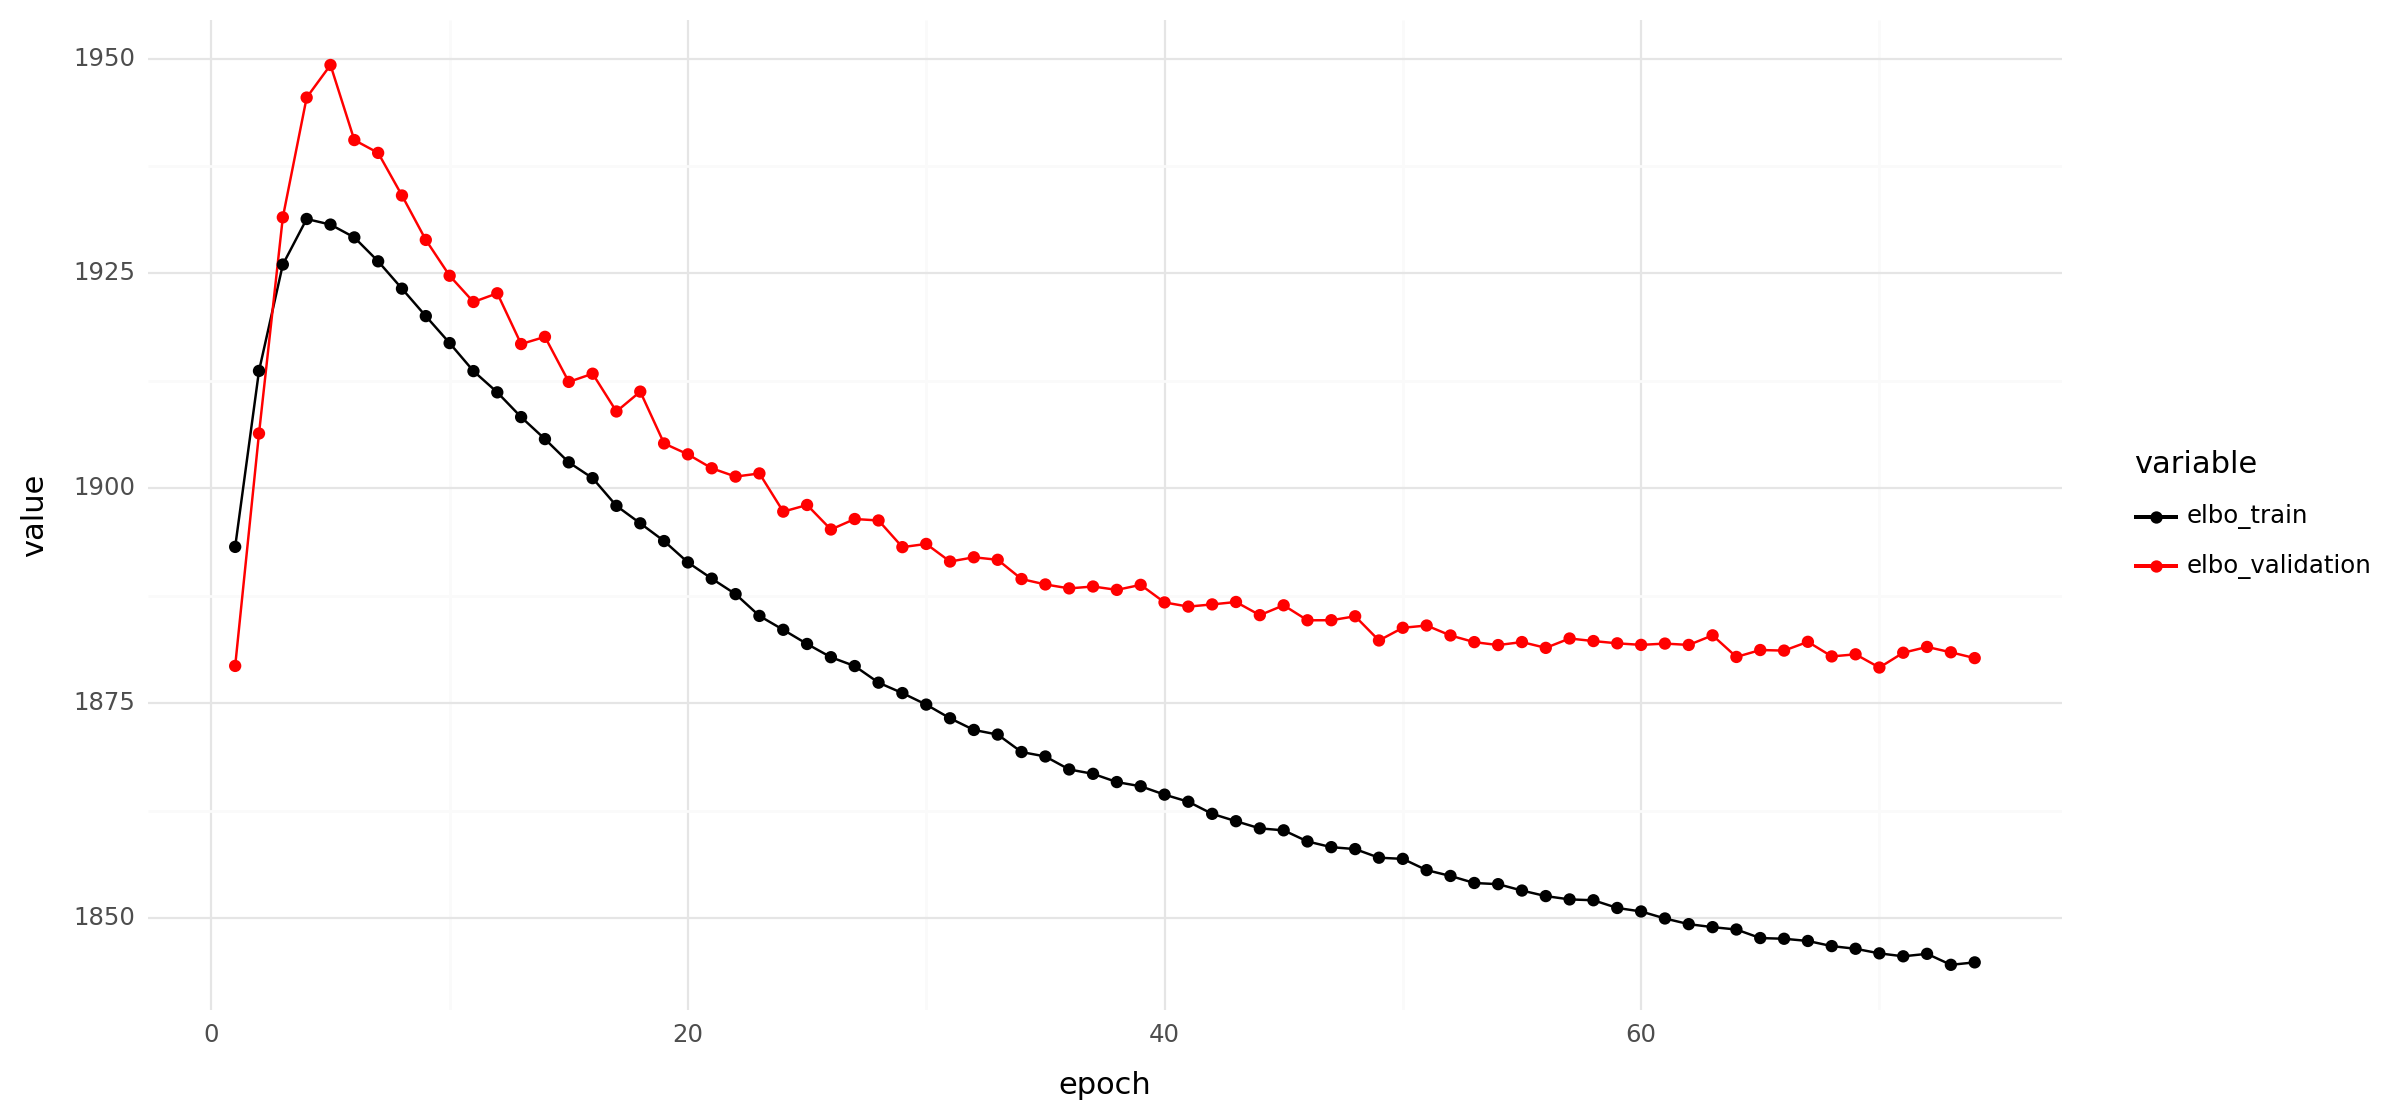

In [27]:
history_df = (
    scanvi_model.history['elbo_train'].astype(float)
    .join(scanvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

### Visualise corrected dataset

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:37)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


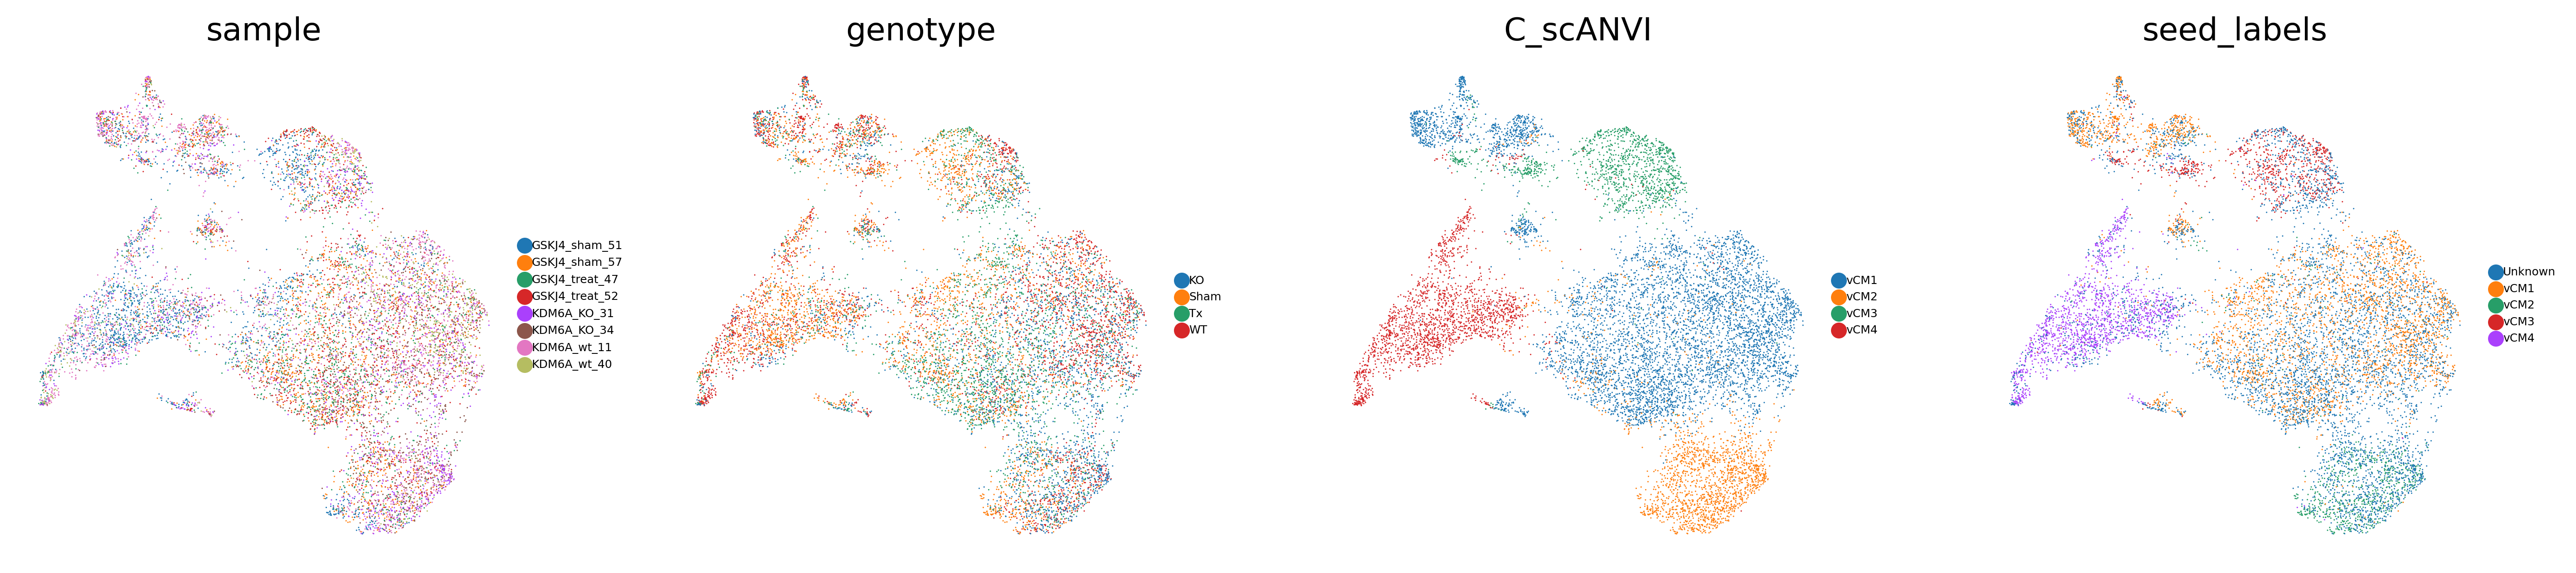

In [28]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.3, spread = 4, random_state = 1712)
sc.pl.umap(adata, frameon = False, color = ['sample', 'genotype', 'C_scANVI', 'seed_labels'], size = 1.5, legend_fontsize = 5, ncols = 4)

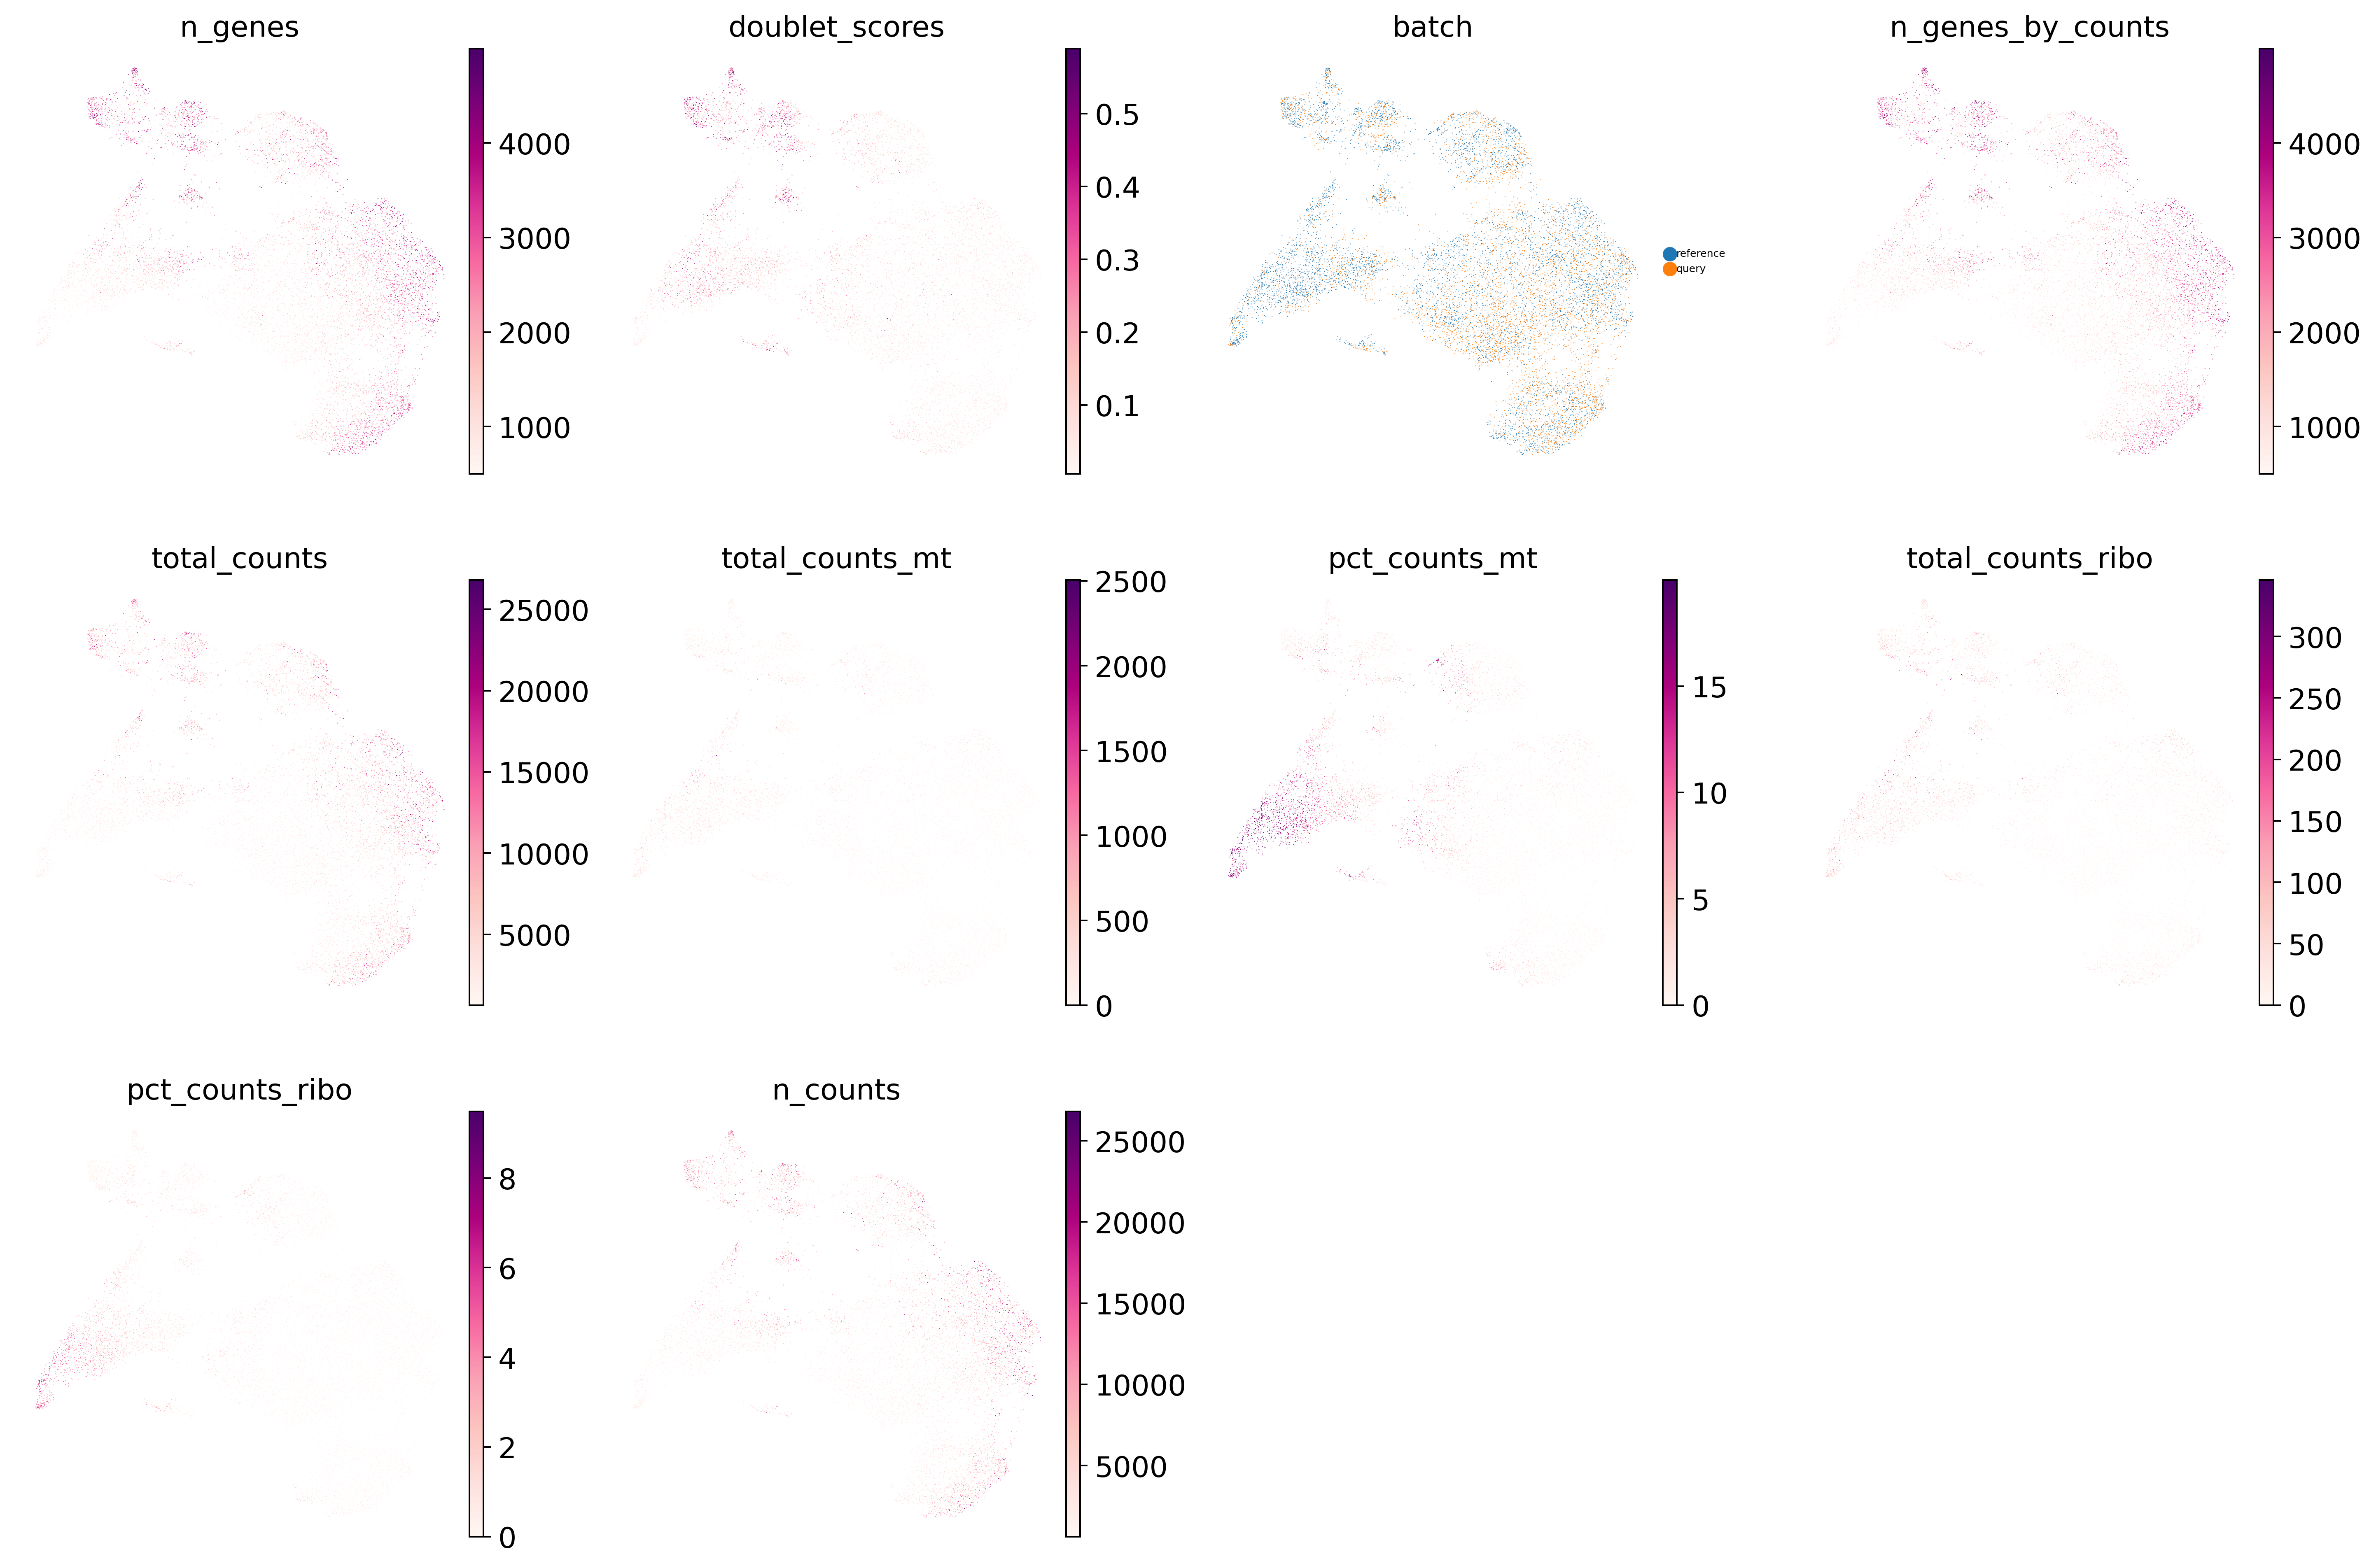

In [29]:
sc.pl.umap(adata, frameon = False, color = ['n_genes', 'doublet_scores', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_counts'], size = 0.6, legend_fontsize = 5, ncols = 4, cmap = 'RdPu')

### Evaluate integration with `scIB-metrics`

In [30]:
sc.pp.pca(adata, svd_solver = 'arpack', random_state = 1712)

computing PCA
    on highly variable genes
    with n_comps=50


ValueError: `A` must be of floating or complex floating data type.

In [ ]:
bm = Benchmarker(
    adata,
    batch_key="sample",
    label_key="C_scANVI",
    embedding_obsm_keys=["X_pca", "X_scVI", "X_scANVI"],
    n_jobs = -1,
)
bm.benchmark()

In [ ]:
bm.plot_results_table()

In [ ]:
bm.plot_results_table(min_max_scale = False)

### Modify object to plot canonical marker genes

In [ ]:
adata_toplot = anndata.AnnData(X = np.sqrt(sc.pp.normalize_total(adata_raw, inplace = False)["X"]), var = adata_raw.var, obs = adata.obs, obsm = adata.obsm)
adata_toplot

In [ ]:
sc.pl.umap(adata_toplot, frameon = False, color = ['C_scANVI', 'Ttn', 'Nppa', 'Dcn', 'Vwf', 'Myh11', 'Rgs4', 'Kcnj8', 'C1qa', 'Cd3e', 'Trem2', 'Adipoq', 'Nrxn1', 'Msln'], size = 0.6, legend_fontsize = 5, ncols = 4, cmap = 'RdPu')

### Visualise proportions

In [ ]:
sc.pl.umap(adata, frameon = False, color = ['sample', 'genotype', 'C_scANVI', 'seed_labels'], size = 0.6, legend_fontsize = 5, ncols = 4)

In [ ]:
bauhaus_colors = ['#FF0000', '#FFFF00', '#000000', '#4D5D53', '#0000FF', '#808080']
sc.pl.umap(adata, frameon = False, color = ['sample'], size = 0.6, legend_fontsize = 5, ncols = 4, palette = bauhaus_colors)

In [ ]:
sc.pl.umap(adata, frameon = False, color = ['C_scANVI'], size = 0.6, legend_fontsize = 5, ncols = 4, palette = bauhaus_colors)

In [ ]:
df = adata_toplot.obs.groupby(['genotype', 'C_scANVI']).size().reset_index(name = 'counts')

grouped = df.groupby('genotype')['counts'].apply(lambda x: x / x.sum() * 100)
grouped = grouped.reset_index()

df['proportions'] = grouped['counts']
df['waffle_counts'] = (df['proportions'] * 10).astype(int)

In [ ]:
tab20_palette = plt.cm.get_cmap('tab20', len(df['C_scANVI'].unique()))


for group in df['genotype'].unique():
    temp_df = df[df['genotype'] == group]
    
    data = dict(zip(temp_df['C_scANVI'], temp_df['waffle_counts']))
    colors = [tab20_palette(i) for i in range(len(temp_df['C_scANVI']))]
    fig = plt.figure(
        FigureClass = Waffle, 
        rows = 5, 
        values = data, 
        title = {'label': f'Genotype {group}', 'loc': 'left', 'fontsize': 14},
        labels = [f"{k} ({v}%)" for k, v in zip(temp_df['C_scANVI'], temp_df['proportions'].round(2))],
        #legend = {'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': len(data), 'framealpha': 0},
        legend = {'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': len(data), 'framealpha': 0, 'fontsize': 14},
        figsize = (40, 4),
        colors = colors
    )
    plt.show()

### Export annotated sample object 

In [ ]:
adata.obs.index = pd.Index(['-'.join(idx.split('-')[:3]) for idx in adata.obs.index])
adata.obs.index

In [ ]:
adata_raw.obs.index = pd.Index(['-'.join(idx.split('-')[:3]) for idx in adata_raw.obs.index])
adata_raw.obs.index

In [ ]:
adata.obs_names

In [ ]:
adata.obs['C_scANVI'].cat.categories

In [ ]:
adata.obs['C_scANVI'].value_counts()

### Export annotated object with raw counts

In [ ]:
adata

In [ ]:
adata_raw

In [ ]:
adata_export = anndata.AnnData(X = adata_raw.X, obs = adata.obs, var = adata_raw.var)
adata_export.obsm['X_scVI'] = adata.obsm['X_scVI'].copy()
adata_export.obsm['X_umap'] = adata.obsm['X_umap'].copy()
adata_export.obsm['X_scANVI'] = adata.obsm['X_scANVI'].copy()
adata_export